In [6]:
import pandas as pd
import seaborn as sns
from pycaret.classification import *

In [2]:
train = pd.read_csv("../data/minseok_EDA2_train.csv")
test = pd.read_csv("../data/minseok_EDA2_test.csv")

In [3]:
print(train.shape)
print(test.shape)

(15000, 69)
(35452, 68)


In [4]:
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,hand,religion,orientation,voted,married,familysize,ASD,nerdiness,Qs_Mach,age_cat
0,0.219430,0.684909,0.645424,0.689224,0.270300,0.580272,0.649525,0.664648,0.287443,0.462615,...,0.550968,0.567721,0.617225,0.549084,0.560104,0.547405,0.54676,1,3.653846,0.559000
1,0.549147,0.490676,0.505430,0.576165,0.538382,0.754382,0.494185,0.537294,0.460687,0.462615,...,0.552290,0.597924,0.521066,0.562683,0.515796,0.547405,0.54676,1,3.269231,0.523114
2,0.549147,0.684909,0.645424,0.576165,0.490014,0.754382,0.649525,0.664648,0.541905,0.523798,...,0.552290,0.597924,0.600253,0.549084,0.529865,0.547405,0.54676,1,3.692308,0.523114
3,0.549147,0.490676,0.505430,0.382335,0.538382,0.427424,0.435168,0.664648,0.460687,0.523798,...,0.550968,0.565894,0.521066,0.549084,0.560104,0.565604,0.54676,1,3.500000,0.564478
4,0.549147,0.490676,0.505430,0.576165,0.490014,0.427424,0.494185,0.413060,0.460687,0.523798,...,0.550968,0.567721,0.521066,0.549084,0.560104,0.573536,0.54676,0,3.461538,0.564478


## Set Environment

In [7]:
clf = setup(data = train, target='nerdiness',
            session_id = 20171184,
            ignore_low_variance = True,
            combine_rare_levels = True, rare_level_threshold = 0.1,
            remove_multicollinearity = True, multicollinearity_threshold = 0.90,
            silent = True
           )

,Description,Value
0,session_id,20171184
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 69)"
5,Missing Values,True
6,Numeric Features,49
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


## Compare Models

In [8]:
top5_models = compare_models(n_select=5, fold=3,  sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7573,0.8425,0.8207,0.7586,0.7884,0.5050,0.5073,0.1700
rf,Random Forest Classifier,0.7580,0.8403,0.8236,0.7582,0.7894,0.5060,0.5088,0.1733
catboost,CatBoost Classifier,0.7497,0.8242,0.8167,0.7510,0.7823,0.4891,0.4917,1.1300
xgboost,Extreme Gradient Boosting,0.7445,0.8168,0.7982,0.7531,0.7748,0.4802,0.4816,0.4433
lightgbm,Light Gradient Boosting Machine,0.7411,0.8130,0.8024,0.7467,0.7734,0.4724,0.4742,0.2800
gbc,Gradient Boosting Classifier,0.7312,0.8029,0.7985,0.7361,0.7660,0.4515,0.4537,0.6000
lda,Linear Discriminant Analysis,0.7294,0.7985,0.7885,0.7384,0.7624,0.4489,0.4506,0.0633
lr,Logistic Regression,0.7311,0.7983,0.7882,0.7405,0.7635,0.4526,0.4540,1.0367
ada,Ada Boost Classifier,0.7267,0.7938,0.7937,0.7328,0.7618,0.4425,0.4448,0.1833
nb,Naive Bayes,0.6922,0.7576,0.7294,0.7168,0.7230,0.3767,0.3768,0.7833


## Create & Tune models

In [9]:
tuned_models = []

In [11]:
model_et = create_model('et', fold = 3)
model_et = tune_model(model_catboost, fold=3, optimize = 'AUC', choose_better = True)
tuned_models.append(model_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7169,0.7906,0.8174,0.7115,0.7608,0.4180,0.4241
1,0.7266,0.7914,0.7946,0.7320,0.7620,0.4420,0.4441
2,0.7291,0.7960,0.7919,0.7361,0.7630,0.4478,0.4494
Mean,0.7242,0.7927,0.8013,0.7265,0.7619,0.4359,0.4392
SD,0.0053,0.0024,0.0114,0.0108,0.0009,0.0129,0.0109


In [16]:
model_rf = create_model('rf', fold = 3)
model_rf = tune_model(model_rf, fold=3, optimize = 'AUC', choose_better = True)
tuned_models.append(model_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7191,0.7811,0.7697,0.7336,0.7512,0.4292,0.4299
1,0.7117,0.7802,0.7298,0.7425,0.7361,0.4185,0.4186
2,0.7119,0.7852,0.7234,0.7459,0.7345,0.4198,0.4200
Mean,0.7143,0.7822,0.7410,0.7406,0.7406,0.4225,0.4228
SD,0.0035,0.0022,0.0205,0.0052,0.0075,0.0048,0.0050


In [17]:
model_catboost = create_model('catboost', fold = 3)
model_catboost = tune_model(model_catboost, fold=3, optimize = 'AUC', choose_better = True)
tuned_models.append(model_catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7589,0.8400,0.8449,0.7493,0.7942,0.5055,0.5109
1,0.7586,0.8418,0.8262,0.7575,0.7904,0.5070,0.5097
2,0.7682,0.8444,0.8163,0.7749,0.7950,0.5288,0.5297
Mean,0.7619,0.8421,0.8292,0.7606,0.7932,0.5138,0.5168
SD,0.0045,0.0018,0.0119,0.0107,0.0020,0.0106,0.0092


In [18]:
model_xgboost = create_model('xgboost', fold = 3)
model_xgboost = tune_model(model_xgboost, fold=3, optimize = 'AUC', choose_better = True)
tuned_models.append(model_xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6451,0.8083,0.9751,0.6116,0.7517,0.2311,0.3279
1,0.6494,0.8028,0.9694,0.6154,0.7529,0.2422,0.3324
2,0.6582,0.8094,0.9756,0.6207,0.7587,0.2616,0.3569
Mean,0.6509,0.8068,0.9734,0.6159,0.7544,0.2450,0.3391
SD,0.0054,0.0029,0.0028,0.0037,0.0031,0.0126,0.0128


In [19]:
model_lightgbm = create_model('lightgbm', fold = 3)
model_lightgbm = tune_model(model_lightgbm, fold=3, optimize = 'AUC', choose_better = True)
tuned_models.append(model_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7311,0.8035,0.8143,0.7292,0.7694,0.4494,0.4533
1,0.7354,0.8078,0.7956,0.7425,0.7682,0.4610,0.4625
2,0.7328,0.8063,0.7888,0.7422,0.7648,0.4561,0.4573
Mean,0.7331,0.8059,0.7996,0.7380,0.7675,0.4555,0.4577
SD,0.0018,0.0018,0.0108,0.0062,0.0020,0.0047,0.0037


## Ensemble model

In [20]:
prediction_models = []

### bagging 

In [21]:
bag_catboost_10 = ensemble_model(model_catboost, n_estimators = 10, fold=3, optimize = 'AUC')
prediction_models.append(bag_catboost_10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7529,0.8341,0.8485,0.7406,0.7909,0.4922,0.4990
1,0.7623,0.8342,0.8314,0.7597,0.7940,0.5144,0.5173
2,0.7674,0.8362,0.8241,0.7698,0.7960,0.5261,0.5278
Mean,0.7608,0.8348,0.8347,0.7567,0.7936,0.5109,0.5147
SD,0.0060,0.0010,0.0103,0.0121,0.0021,0.0141,0.0119


In [22]:
bag_catboost_50 = ensemble_model(model_catboost, n_estimators = 50, fold=3, optimize = 'AUC')
prediction_models.append(bag_catboost_50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7571,0.8355,0.8543,0.7432,0.7949,0.5008,0.5081
1,0.7640,0.8354,0.8288,0.7631,0.7946,0.5184,0.5208
2,0.7745,0.8374,0.8319,0.7751,0.8025,0.5405,0.5424
Mean,0.7652,0.8361,0.8383,0.7605,0.7973,0.5199,0.5238
SD,0.0071,0.0009,0.0113,0.0132,0.0037,0.0163,0.0141


### boosting

In [25]:
boo_catboost = ensemble_model(model_catboost, method = 'Boosting', fold=3, optimize='AUC')
prediction_models.append(boo_catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7494,0.8371,0.8366,0.7416,0.7863,0.4862,0.4913
1,0.7591,0.8398,0.8185,0.7620,0.7892,0.5091,0.5109
2,0.7648,0.8444,0.8179,0.7695,0.7930,0.5213,0.5226
Mean,0.7578,0.8404,0.8243,0.7577,0.7895,0.5055,0.5083
SD,0.0063,0.0030,0.0087,0.0118,0.0027,0.0146,0.0129


### blending

In [23]:
blend_3_soft = blend_models(estimator_list=[model_catboost, model_xgboostgboost, model_lightgbm], method='soft', fold=3, optimize='AUC')
prediction_models.append(blend_3_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7591,0.8342,0.8382,0.7527,0.7931,0.5069,0.5111
1,0.7571,0.8344,0.8133,0.7619,0.7868,0.5054,0.5069
2,0.7691,0.8368,0.8163,0.7760,0.7956,0.5306,0.5315
Mean,0.7618,0.8351,0.8226,0.7635,0.7918,0.5143,0.5165
SD,0.0052,0.0012,0.0111,0.0096,0.0037,0.0115,0.0107


In [26]:
blend_4_soft = blend_models(estimator_list=[model_catboost, model_xgboost ,model_lightgbm, model_et], method='soft', fold=3, optimize='AUC')
prediction_models.append(blend_4_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7609,0.8436,0.8444,0.7520,0.7955,0.5099,0.5149
1,0.7574,0.8430,0.8138,0.7620,0.7871,0.5060,0.5075
2,0.7659,0.8450,0.8158,0.7721,0.7933,0.5240,0.5250
Mean,0.7614,0.8439,0.8247,0.7620,0.7920,0.5133,0.5158
SD,0.0035,0.0008,0.0140,0.0082,0.0036,0.0077,0.0072


In [27]:
blend_5_soft = blend_models(estimator_list=tuned_models, method='soft', fold=3, optimize='AUC')
prediction_models.append(blend_5_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7611,0.8450,0.8454,0.7518,0.7959,0.5104,0.5155
1,0.7609,0.8443,0.8174,0.7647,0.7902,0.5129,0.5145
2,0.7694,0.8469,0.8210,0.7740,0.7968,0.5307,0.5319
Mean,0.7638,0.8454,0.8279,0.7635,0.7943,0.5180,0.5206
SD,0.0039,0.0011,0.0125,0.0091,0.0029,0.0090,0.0080


### stacking

In [28]:
stack_3_best = stack_models(estimator_list=[model_lightgbm, model_xgboost,model_et],
                            meta_model=model_catboost,
                           fold = 3,
                           optimize = 'AUC',
                           choose_better= True)
prediction_models.append(stack_3_best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7566,0.8440,0.8423,0.7477,0.7922,0.5009,0.5061
1,0.7534,0.8412,0.8122,0.7576,0.7840,0.4976,0.4992
2,0.7648,0.8463,0.8101,0.7735,0.7914,0.5221,0.5229
Mean,0.7583,0.8438,0.8215,0.7596,0.7892,0.5069,0.5094
SD,0.0048,0.0021,0.0147,0.0106,0.0037,0.0109,0.0099


## Predict

In [30]:
prediction_models

[BaggingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x0000023C08338880>,
                   bootstrap=True, bootstrap_features=False, max_features=1.0,
                   max_samples=1.0, n_estimators=10, n_jobs=None,
                   oob_score=False, random_state=20171184, verbose=0,
                   warm_start=False),
 BaggingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x0000023C084629A0>,
                   bootstrap=True, bootstrap_features=False, max_features=1.0,
                   max_samples=1.0, n_estimators=50, n_jobs=None,
                   oob_score=False, random_state=20171184, verbose=0,
                   warm_start=False),
 VotingClassifier(estimators=[('catboost',
                               <catboost.core.CatBoostClassifier object at 0x0000023C0833D1C0>),
                              ('xgboost',
                               XGBClassifier(base_score=0.5, booster='gbtree',
                                   

In [31]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7672,0.8431,0.8107,0.7816,0.7959,0.5251,0.5256


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7740
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.5634
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9314
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8956
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8702
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7903
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9227
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9369


BaggingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7705,0.8437,0.8091,0.7870,0.7979,0.5325,0.5328


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8222
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.5867
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9392
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9282
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8552
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8015
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9023
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9389


VotingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7572,0.8367,0.7722,0.7895,0.7807,0.5087,0.5089


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7514
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7382
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9235
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9447
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.6615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8343
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7883
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9311
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9402


AdaBoostClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7683,0.8455,0.7984,0.7899,0.7942,0.5291,0.5292


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7980
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.5767
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9533
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9800
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8975
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7880
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8960
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9435


VotingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7614,0.8406,0.7758,0.7934,0.7845,0.5173,0.5175


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7111
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.6812
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8477
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9011
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.6511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.7582
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7487
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8859
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8977


VotingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7632,0.8442,0.7802,0.7934,0.7867,0.5205,0.5206


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7109
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.6609
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8361
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8988
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.6749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.7446
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7410
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8547
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8601


StackingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7592,0.8402,0.7540,0.8037,0.7781,0.5154,0.5167


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8422
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.5705
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8941
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9537
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.6724
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8046
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9122
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9446


In [32]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

ExtraTreesClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7385,0.8304,0.7012,0.8065,0.7502,0.4787,0.4838


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.59
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.51
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.62
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.77
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.53
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.63
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.75
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.77


RandomForestClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7598,0.8433,0.7778,0.7900,0.7838,0.5137,0.5138


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.71
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.58
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.79
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.89
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.69
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.71
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.73
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.71


CatBoostClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7643,0.8443,0.7897,0.7894,0.7895,0.5217,0.5217


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.6624
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.6209
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9283
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9827
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8105
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7802
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9247
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8978


XGBClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7349,0.8067,0.7226,0.7866,0.7533,0.4681,0.4700


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8853
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.8728
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9268
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9664
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.5613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8591
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8000
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9629
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9952


LGBMClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7327,0.8091,0.7520,0.7663,0.7591,0.4590,0.4592


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,VCL14_0.41791045665740967,engnat_0.5738828182220459,engnat_not_available,voted_0.5626827478408813,voted_not_available,ASD_0.6641137599945068,ASD_not_available,nerdiness,Label,Score
0,0.403028,0.490676,0.505430,0.689224,0.490014,0.427424,0.494185,0.537294,0.460687,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7066
1,0.549147,0.414692,0.645424,0.689224,0.384088,0.427424,0.388759,0.664648,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.7210
2,0.549147,0.684909,0.645424,0.689224,0.553289,0.754382,0.649525,0.537294,0.675138,0.523798,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.9155
3,0.696582,0.414692,0.505430,0.689224,0.270300,0.347197,0.649525,0.458585,0.367133,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.8851
4,0.696582,0.684909,0.645424,0.689224,0.538382,0.347197,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.6368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496,0.696582,0.684909,0.645424,0.689224,0.679836,0.580272,0.649525,0.664648,0.675138,0.641272,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,1,0.8333
4497,0.696582,0.288533,0.505430,0.382335,0.538382,0.580272,0.649525,0.313116,0.541905,0.462615,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.7846
4498,0.549147,0.490676,0.505430,0.251900,0.270300,0.269187,0.494185,0.313116,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9058
4499,0.219430,0.684909,0.302714,0.382335,0.384088,0.427424,0.388759,0.458585,0.460687,0.315011,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0.9276


## Finalize best models

In [35]:
final_tuend_cat = finalize_model(model_catboost)

In [34]:
final_blend_5_soft = finalize_model(blend_5_soft)

In [33]:
final_boo_catboost = finalize_model(boo_catboost)

In [37]:
for model in [final_tuend_cat, final_boo_catboost, final_blend_5_soft]:
    prediction = predict_model(model, data=test)
    sample_submission = pd.read_csv('../data/sample_submission.csv')
    sample_submission['nerdiness'] = prediction['Label']
    sample_submission['Score'] = prediction['Score']
    display(sample_submission.head())
    sample_submission.to_csv(f'auto_minseok4_{model.__class__.__name__}.csv',index=False)

,index,nerdiness,Score
0,0,0,0.8627
1,1,1,0.8197
2,2,1,0.9705
3,3,1,0.6751
4,4,1,0.9342


,index,nerdiness,Score
0,0,0,0.8952
1,1,1,0.8021
2,2,1,0.9734
3,3,1,0.7395
4,4,1,0.9437


,index,nerdiness,Score
0,0,0,0.7479
1,1,1,0.7989
2,2,1,0.9074
3,3,1,0.6422
4,4,1,0.8226


## create submission

In [53]:
sub = pd.read_csv("../submission/auto_minseok4_AdaBoostClassifier.csv")

In [54]:
sub.head()

,index,nerdiness,Score
0,0,0,0.8952
1,1,1,0.8021
2,2,1,0.9734
3,3,1,0.7395
4,4,1,0.9437


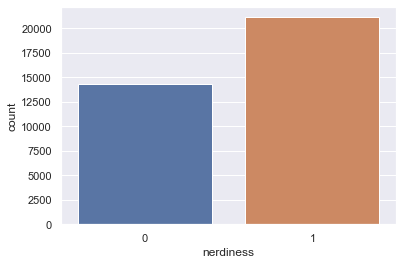

In [55]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="nerdiness", data=sub)

In [56]:
len(sub)

35452

In [57]:
for i in range(len(sub)):
    if (sub['nerdiness'][i] == 1) and (sub['Score'][i] > 0.8):
        sub['nerdiness'][i] = 1
    else: sub['nerdiness'][i] = 0

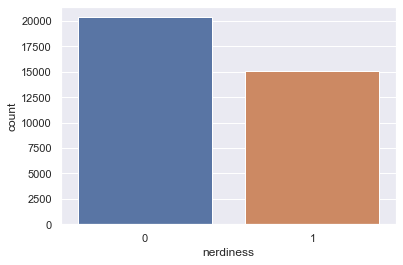

In [58]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="nerdiness", data=sub)

In [60]:
sub.drop(columns='Score', axis=1, inplace=True)

In [61]:
sub.head()

,index,nerdiness
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


In [65]:
sub.shape

(35452, 2)

In [66]:
sub.to_csv('../submission/auto_misenok4.csv', index=False)